# Анализ поведения пользователей приложения <a class="tocSkip">

**Цель исследования:**  
Проанализировать поведение пользователей развлекательного приложения Procrastinate Pro+ с целью выделения причин  неэффективности привлечения пользователей и выработки рекомендаций для отдела маркетинга.   

##  Загрузка данных и подготовка их к анализу

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# загрузка данных
visits, orders, costs = (
    pd.read_csv('/datasets/visits_info.csv'),  # журнал сессий
    pd.read_csv('/datasets/orders_info.csv'),  # покупки   
    pd.read_csv('/datasets/costs_info.csv'),  # траты на рекламу
)

In [3]:
display(visits, orders, costs)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,01.05.2019 02:36,01.05.2019 02:45
1,278965908054,United States,iPhone,organic,01.05.2019 04:46,01.05.2019 04:47
2,590706206550,United States,Mac,organic,01.05.2019 14:09,01.05.2019 15:32
3,326433527971,United States,Android,TipTop,01.05.2019 00:29,01.05.2019 00:54
4,349773784594,United States,Mac,organic,01.05.2019 03:33,01.05.2019 03:57
...,...,...,...,...,...,...
309896,329994900775,UK,PC,LeapBob,31.10.2019 13:28,31.10.2019 14:39
309897,334903592310,France,PC,lambdaMediaAds,31.10.2019 22:14,31.10.2019 22:39
309898,540102010126,Germany,PC,organic,31.10.2019 01:40,31.10.2019 01:41
309899,308736936846,Germany,Mac,organic,31.10.2019 07:37,31.10.2019 07:37


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
...,...,...,...
40207,651604369137,2019-10-31 16:19:07,4.99
40208,275341387049,2019-10-31 01:17:17,4.99
40209,374656616484,2019-10-31 06:17:29,4.99
40210,168548862926,2019-10-31 22:46:19,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0
1796,2019-10-24,lambdaMediaAds,6.4
1797,2019-10-25,lambdaMediaAds,8.8
1798,2019-10-26,lambdaMediaAds,8.8


- Описание данных  
  
Таблица visits хранит лог сервера с информацией о посещениях сайта:  

    User Id — уникальный идентификатор пользователя,  
    Region — страна пользователя,  
    Device — тип устройства пользователя,  
    Channel — идентификатор источника перехода,  
    Session Start — дата и время начала сессии,  
    Session End — дата и время окончания сессии.  
Таблица orders содержит информацию о покупках:

    User Id — уникальный идентификатор пользователя,
    Event Dt — дата и время покупки,
    Revenue — сумма заказа.
Таблица costs содержит информацию о расходах на рекламу:

    Channel — идентификатор рекламного источника,
    Dt — дата проведения рекламной кампании,
    Costs — расходы на эту кампанию.

Мы видим, что столбцы таблиц записаны в разном регистре и содержат пробелы между словами. Также в таблицах visits и costs строковые значения записаны в разных регистрах. Для соблюдения единообразия изменим названия колонок и приведем к нижнему регистру данные в таблицах. 

In [4]:
# переименование колонок
visits.columns = ['user_id', 'region', 'device', 'channel','session_start', 'session_end']
orders.columns = ['user_id', 'event_dt', 'revenue']
costs.columns = ['dt', 'channel', 'costs']

In [5]:
# функция приведения к нижнему регистру
def string_lower(data, columns=[]):
    for col in columns:
        data[col] = data[col].str.lower()
    return data

In [6]:
# приведение к нижнему регистру
string_lower(visits, ['region', 'device', 'channel'])
string_lower(costs, ['channel'])

,dt,channel,costs
0,2019-05-01,faceboom,113.3
1,2019-05-02,faceboom,78.1
2,2019-05-03,faceboom,85.8
3,2019-05-04,faceboom,136.4
4,2019-05-05,faceboom,122.1
...,...,...,...
1795,2019-10-23,lambdamediaads,4.0
1796,2019-10-24,lambdamediaads,6.4
1797,2019-10-25,lambdamediaads,8.8
1798,2019-10-26,lambdamediaads,8.8


Посмотрим на общую информацию о таблицах.

In [7]:
# список таблиц
list_of_data = [visits, orders, costs]

In [8]:
# общая информация о таблицах
for data in list_of_data:
    display(data.info())    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
user_id          309901 non-null int64
region           309901 non-null object
device           309901 non-null object
channel          309901 non-null object
session_start    309901 non-null object
session_end      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
user_id     40212 non-null int64
event_dt    40212 non-null object
revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

Пропуски в таблицах отсутствуют. Однако колонки с датами имеют тип данных object. Для дальнейшей работы с датой необходимо их преобразовать в тип datetime.

In [9]:
# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'], format='%d.%m.%Y %H:%M')
visits['session_end'] = pd.to_datetime(visits['session_end'], format='%d.%m.%Y %H:%M')
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

Проверим таблицы на наличие дубликатов.

In [10]:
# проверка на дубликаты
for data in list_of_data:
    print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 0
Количество дубликатов: 0
Количество дубликатов: 0


### Вывод
Мы единообразно изменили названия колонок и привели к нижнему регистру данные в таблицах, привели данные к нужному типу и проверили на наличие пропусков и дубликатов. Теперь данные готовы к дальнейшему анализу.

## Исследовательский анализ данных

- Создадим пользовательские профили и определим минимальную и максимальную даты привлечения пользователей.

In [11]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles 

In [12]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head(10) 

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,faceboom,mac,united states,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:00,faceboom,iphone,united states,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:00,organic,iphone,france,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:00,adnonsense,pc,germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:00,yrabbit,iphone,united states,2019-10-02,2019-10-01,False,0.230769
5,34186288,2019-05-09 17:29:00,organic,android,united states,2019-05-09,2019-05-01,False,0.000000
6,38448301,2019-08-16 11:56:00,organic,android,united states,2019-08-16,2019-08-01,False,0.000000
7,46006712,2019-06-30 03:46:00,adnonsense,android,france,2019-06-30,2019-06-01,True,1.008000
8,58263264,2019-05-11 19:18:00,faceboom,iphone,united states,2019-05-11,2019-05-01,False,1.128205
9,59835779,2019-05-11 21:13:00,mediatornado,iphone,united states,2019-05-11,2019-05-01,False,0.250435


In [13]:
# минимальная и максисмальная дата привлечения пользователей
print('Минимальная дата привлечения пользователей', profiles['dt'].min())
print('Максимальная дата привлечения пользователей', profiles['dt'].max())

Минимальная дата привлечения пользователей 2019-05-01
Максимальная дата привлечения пользователей 2019-10-27


- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

Напишем функцию, которая будет считать количество пользователей и долю платящих пользователей по различным параметрам группировки. 

In [14]:
# срез таблицы profiles по признаку платящего пользователя
profiles_payer = profiles.query('payer == True')

In [15]:
# функция для подсчета кол-ва пользователей (в т.ч. платящих) по различным параметрам группировки

def count_users_by_param(data_1, data_2, column):    
    # группировка всех пользователей по параметру
    total_users = data_1.groupby(column).agg({'user_id': 'nunique'}) 
    
    # группировка платящих пользователей по параметру
    paying_users = data_2.groupby(column).agg({'user_id': 'nunique'})
    
    # объединение таблиц по общему столбцу
    users = total_users.merge(paying_users, on=column, how='left').rename(columns={'user_id_x': 'total_users',
                                                                                   'user_id_y': 'paying_users'})
    
    # расчет доли платящих пользователей
    users['paying_users_%'] = (users['paying_users'] / users['total_users'] * 100).round(2)
    
    # сортировка
    users = users.sort_values(by='paying_users_%', ascending=False)    
    
    return users

In [16]:
# список названий таблиц 
list_of_titles = ['Количество пользователей по странам', 
                  'Устройства, которые предпочитают пользователи', 
                  'Каналы привлечения пользователей']

In [17]:
# количество пользователей по странам
users_by_region = count_users_by_param(profiles, profiles_payer, 'region')
users_by_region.style.set_caption(list_of_titles[0])

,total_users,paying_users,paying_users_%
region,,,
united states,100002,6902,6.9
germany,14981,616,4.11
uk,17575,700,3.98
france,17450,663,3.8


- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [18]:
# количество пользователей по устройствам
users_by_device = count_users_by_param(profiles, profiles_payer, 'device')
users_by_device.style.set_caption(list_of_titles[1])

,total_users,paying_users,paying_users_%
device,,,
mac,30042,1912,6.36
iphone,54479,3382,6.21
android,35032,2050,5.85
pc,30455,1537,5.05


- Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [19]:
# количество пользователей по каналам привлечения
users_by_channel = count_users_by_param(profiles, profiles_payer, 'channel')
users_by_channel.style.set_caption(list_of_titles[2])

,total_users,paying_users,paying_users_%
channel,,,
faceboom,29144,3557,12.2
adnonsense,3880,440,11.34
lambdamediaads,2149,225,10.47
tiptop,19561,1878,9.6
rocketsuperads,4448,352,7.91
wahoonetbanner,8553,453,5.3
yrabbit,4312,165,3.83
mediatornado,4364,156,3.57
leapbob,8553,262,3.06


### Вывод
1. Приложением пользуются клиенты из США, Великобритании, Франции и Германии. Самое большое количество пользователей из США - 100 тыс. человек. Это в 5 - 6 раз больше чем из остальных стран. В остальных странах количество пользователей от 15 до 17 тыс. человек. Больше всего платящих пользователей также из США - 6,9 тыс. человек или почти 7% от общего числа пользователей из США, в остальных странах доля платящих пользователей составляет около 4%. 
  
2. Клиенты приложения пользуются следующими устройствами: iPhone, Andriod, PC и Mac. Платящие пользователи предпочитают использовать iPhone 3,3 тыс. платящих пользователей, на остальные устройства приходится от 1,5 до 2 тыс. платящих пользователей. Самая большая доля платящих пользователей на Mac - это 6,9% от общего числа пользователей Mac, самая маленькая доля на РС - 5% от общего числа пользователей РС.   
  
3. Пользователи приходят из 7 различных каналов. Самое большое количество пользователей пришло из канала organic - 56 тыс. человек, однако больше всего платящих пользователей из канала faceboom	- 3,5 тыс. человек. Также много платящих пользователей из каналов tiptop - 1,8 тыс. человек и organic - 1,1 тыс человек. Но если посмотреть на долю платящих пользователей, то самые высокие показатели у каналов faceboom и adnonsense - 12% и 11% от общего числа пользователей этих каналов соответственно. А вот самый низкий процент платящих пользователей, как и ожидалось, из канала organic - всего 2,1%.

4. В целом только 5,9% пользователей от общего количества становятся платящими. 

## Расчет метрик

### Продукт
-    Сколько людей пользуются в день, неделю, месяц?

Выясним пользовательскую активность. Для этого рассчитаем DAU, WAU и MAU и отобразим изменения метрик во времени на графиках.

In [20]:
# выделяем номер месяца, недели и дату из времени начала сессии
visits['session_month'] = visits['session_start'].dt.month
visits['session_week'] = visits['session_start'].dt.week
visits['session_date'] = visits['session_start'].dt.date

In [21]:
# расчет DAU, WAU, MAU
dau_total = (
    visits.groupby('session_date')
    .agg({'user_id': 'nunique'})
    .mean()
)

wau_total = (
    visits.groupby('session_week')
    .agg({'user_id': 'nunique'})
    .mean()
)

mau_total = (
    visits.groupby('session_month')
    .agg({'user_id': 'nunique'})
    .mean()
)

print('Среднее количество пользователей в приложении в день:', int(dau_total), 'человек')
print('Среднее количество пользователей в приложении в неделю:', int(wau_total), 'человек')
print('Среднее количество пользователей в приложении в месяц:', int(mau_total), 'человек')

Среднее количество пользователей в приложении в день: 1684 человек
Среднее количество пользователей в приложении в неделю: 8353 человек
Среднее количество пользователей в приложении в месяц: 28989 человек


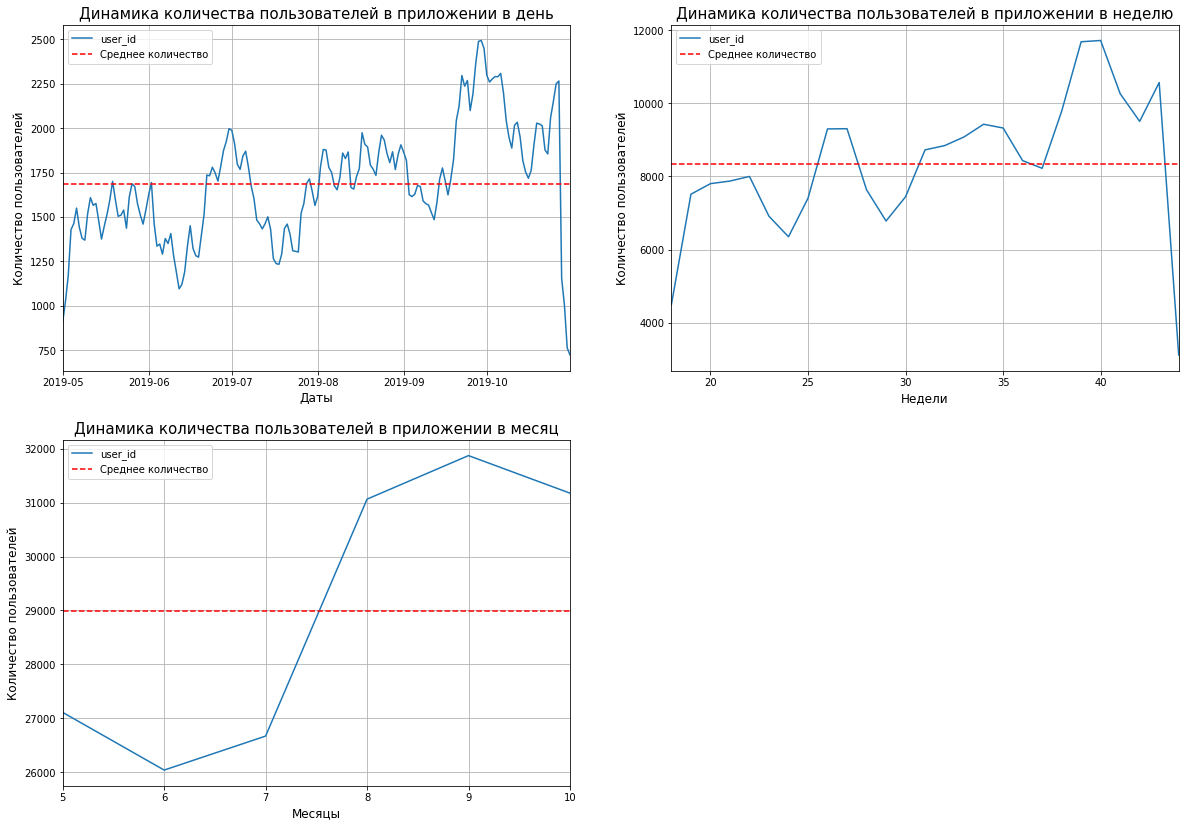

In [22]:
# график динамики количества пользователей в приложении 

dict_of_columns_lables_date = ({'session_date': 'Даты', 'session_week': 'Недели', 'session_month': 'Месяцы'})
list_of_lables_date = ['день', 'неделю', 'месяц']
list_of_avg_level = [1684, 8353, 28989]

plt.figure(figsize=(20, 14))
i=1
j=0
for key in dict_of_columns_lables_date:
    (
    visits.groupby(key)
        .agg({'user_id': 'nunique'})
        .plot(grid=True, ax=plt.subplot(2, 2, i))
    )  
    plt.axhline(y=list_of_avg_level[j], color='red', linestyle='--', label='Среднее количество')
    plt.legend()
    plt.title('Динамика количества пользователей в приложении в {}'.format(list_of_lables_date[j]), fontsize=15)
    plt.xlabel('{}'.format(dict_of_columns_lables_date[key]), fontsize=12) 
    plt.ylabel('Количество пользователей', fontsize=12)
    i += 1
    j += 1

На первом графике видны колебания количества посетителей в день: снижение их количества к середине месяца и увеличение к концу месяца. Если рассматривать ежемесячное количество пользователей, то можно наблюдать **резкий рост их количества в июле: с 26,8 тыс. человек до 31 тыс. человек**. В августе также наблюдался рост на 800 человек, однако в сентября можно заметить спад примерно на тоже самое количество. В целом ежемесячное количество посетителей за весь период выросло с 27 до 31,2 тыс. человек.  

-   Сколько сессий в день?

Изучим число пользовательских сессий и построим гистограмму, отражающую распределение общего числа сессий в день.

Text(0.5, 0, 'Количество сессий в день')

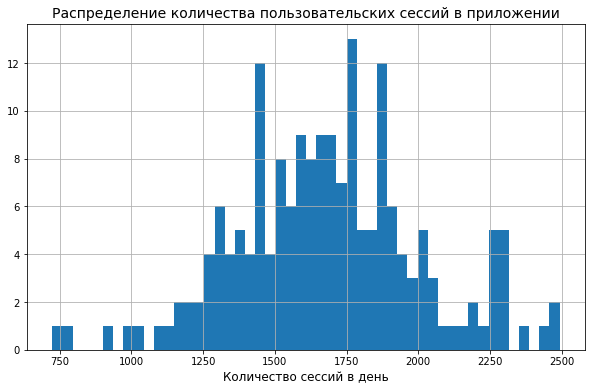

In [23]:
# гистограмма распределение общего числа сессий в день
visits.groupby('session_date').agg({'session_start': 'count'}).hist(bins=50, figsize=(10,6))
plt.title('Распределение количества пользовательских сессий в приложении', fontsize=14)
plt.xlabel('Количество сессий в день', fontsize=12) 

In [24]:
print('Среднее количество сессий в день:', int(visits.groupby('session_date').agg({'session_start': 'count'}).mean()))

Среднее количество сессий в день: 1684


Количество пользовательских сессий колеблется от 750 до 2500 сессий в день. В целом можно наблюдать нормальное распределение их количества. В основном совершается от 1250 до 2250 пользовательских сессий в день, пики приходятся на 1400, 1750 и 1850 сессий в день - это наиболее частые показатели.

-    Сколько длится одна сессия?

Узнаем, сколько длится одна сессия и построим гистограмму, отражающую распределение длительности сессий, а также сделаем таблицу с параметрами распределения.

Text(0, 0.5, 'Количество сессий')

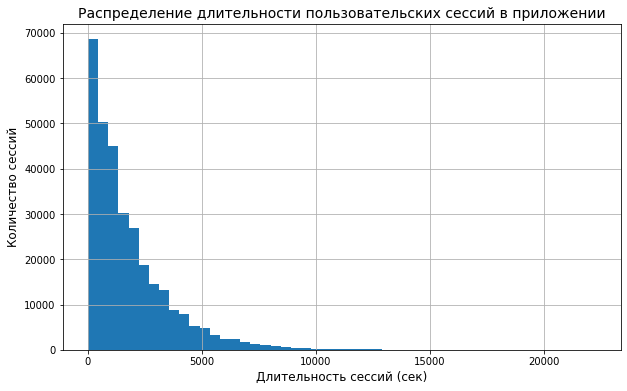

In [25]:
# расчет продолжительности одной сессии 
visits['session_duration_sec'] = (
    visits['session_end'] - visits['session_start']
).dt.seconds

# гистограмма распределение длительности сессий
visits['session_duration_sec'].hist(bins=50, figsize=(10,6))
plt.title('Распределение длительности пользовательских сессий в приложении', fontsize=14)
plt.xlabel('Длительность сессий (сек)', fontsize=12) 
plt.ylabel('Количество сессий', fontsize=12) 

In [26]:
# статистическое описание распределения длительности сессий
visits['session_duration_sec'].describe()

count    309901.000000
mean       1800.084801
std        1803.189827
min           0.000000
25%         540.000000
50%        1260.000000
75%        2520.000000
max       22260.000000
Name: session_duration_sec, dtype: float64

Пик распределения длительности сессий находится около нуля секунд. И это нормально — в цифровых сервисах очень многие сессии заканчиваются техническими ошибками. **Медианное значение продолжительности сессий составляет 1250 секунд, то есть половина сессий длятся 21 минуту и более.** Лишь 25% сессий составляет не более 9 минут, а аномально длинные сессии составляют от 83 минут до 6 часов.  

### Продажи

- Когда люди начинают покупать?

Исследуем, сколько времени в среднем проходит с момента первого посещения до покупки.

In [27]:
# определние времени первой покупки
first_order = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .rename(columns={'event_dt': 'first_event'})
        .reset_index()
    )

# добавление профилей платящих пользователей 
profiles_payer = first_order.merge(profiles_payer, on='user_id', how='right')

# расчет времени до первой покупки
profiles_payer['time_to_first_purchase'] = (profiles_payer['first_event'] - profiles_payer['first_ts']).dt.total_seconds()

print('Среднее время от первого посещения до покупки:', int(profiles_payer['time_to_first_purchase'].mean()/60/60), 'часов.')

Среднее время от первого посещения до покупки: 45 часов.


- Сколько покупок делает в среднем платящий пользователь за месяц, неделю, день?

Рассчитаем среднее число покупок на одного покупателя за день, неделю и месяц и построим графики изменения этих метрик во времени.

In [28]:
# выделяем номер месяца, недели и дату из времени покупки
orders['event_month'] = orders['event_dt'].dt.month
orders['event_week'] = orders['event_dt'].dt.week
orders['event_date'] = orders['event_dt'].dt.date

In [29]:
# среднее число покупок на одного покупателя
avg_purchases_day = (
    orders.groupby('event_date')
    .agg({'revenue': 'count', 'user_id': 'nunique'})
)
avg_purchases_day['avg'] = avg_purchases_day['revenue'] / avg_purchases_day['user_id']

avg_purchases_week = (
    orders.groupby('event_week')
    .agg({'revenue': 'count', 'user_id': 'nunique'})
)
avg_purchases_week['avg'] = avg_purchases_week['revenue'] / avg_purchases_week['user_id']

avg_purchases_month = (
    orders.groupby('event_month')
    .agg({'revenue': 'count', 'user_id': 'nunique'})
)
avg_purchases_month['avg'] = avg_purchases_month['revenue'] / avg_purchases_month['user_id']

print('Среднее количество покупок на одного пользователя в день:', avg_purchases_day['avg'].mean().round(2))
print('Среднее количество покупок на одного пользователя в неделю:', avg_purchases_week['avg'].mean().round(2))
print('Среднее количество покупок на одного пользователя в месяц:', avg_purchases_month['avg'].mean().round(2))

Среднее количество покупок на одного пользователя в день: 1.0
Среднее количество покупок на одного пользователя в неделю: 1.33
Среднее количество покупок на одного пользователя в месяц: 2.23


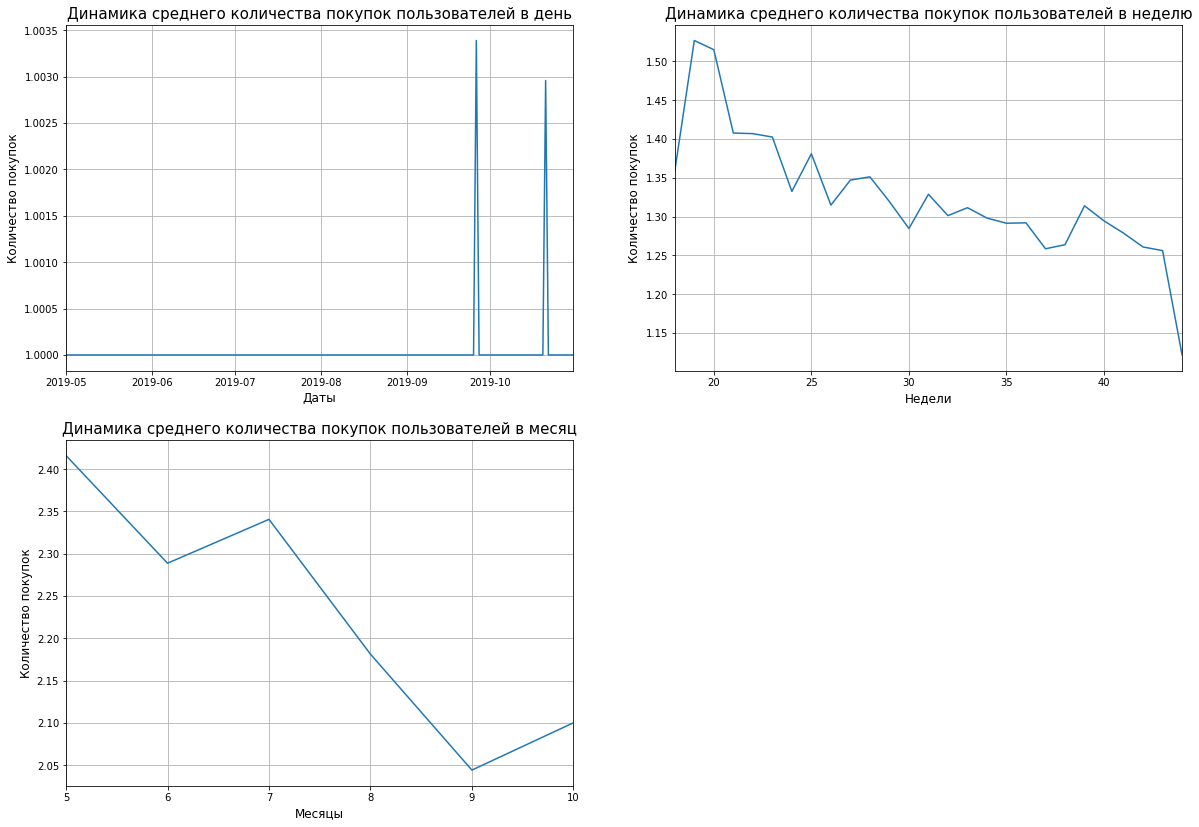

In [30]:
# график динамики среднего количества покупок пользователей 
list_of_data_purchases = [avg_purchases_day, avg_purchases_week, avg_purchases_month]

plt.figure(figsize=(20, 14))
i=1
j=0
for key in dict_of_columns_lables_date:
    list_of_data_purchases[j]['avg'].plot(grid=True, ax=plt.subplot(2, 2, i))
    plt.title('Динамика среднего количества покупок пользователей в {}'.format(list_of_lables_date[j]), fontsize=15)
    plt.xlabel('{}'.format(dict_of_columns_lables_date[key]), fontsize=12) 
    plt.ylabel('Количество покупок', fontsize=12)
    i += 1
    j += 1   

Пользователи делают в среднем не более одной покупки в день и от 1 до 1,5 покупок в неделю. Если рассмотреть количество покупок в месяц, то мы видим, что мае - июне пользователи совершали в среднем 2,4 - 2,3 покупки в месяц. Однако этот показатель резко снизился в июле и августе до 2 покупок в месяц. В октябре наблюдается небольшой рост.

- Какой средний чек за месяц, неделю, день?

Для начала посмотрим какой средний чек в целом за период.

In [31]:
print('Средний чек: {}$'.format(orders['revenue'].mean().round(2)))

Средний чек: 5.37$


Далее рассчитаем средний чек за день, неделю и месяц и построим графики изменения этих метрик во времени.

In [32]:
# расчет среднего чека за день, неделю, месяц
avg_revenue_day = (
    orders.groupby('event_date')
    .agg({'revenue': 'mean'})
)

avg_revenue_week = (
    orders.groupby('event_week')
    .agg({'revenue': 'mean'})
)

avg_revenue_month = (
    orders.groupby('event_month')
    .agg({'revenue': 'mean'})
)

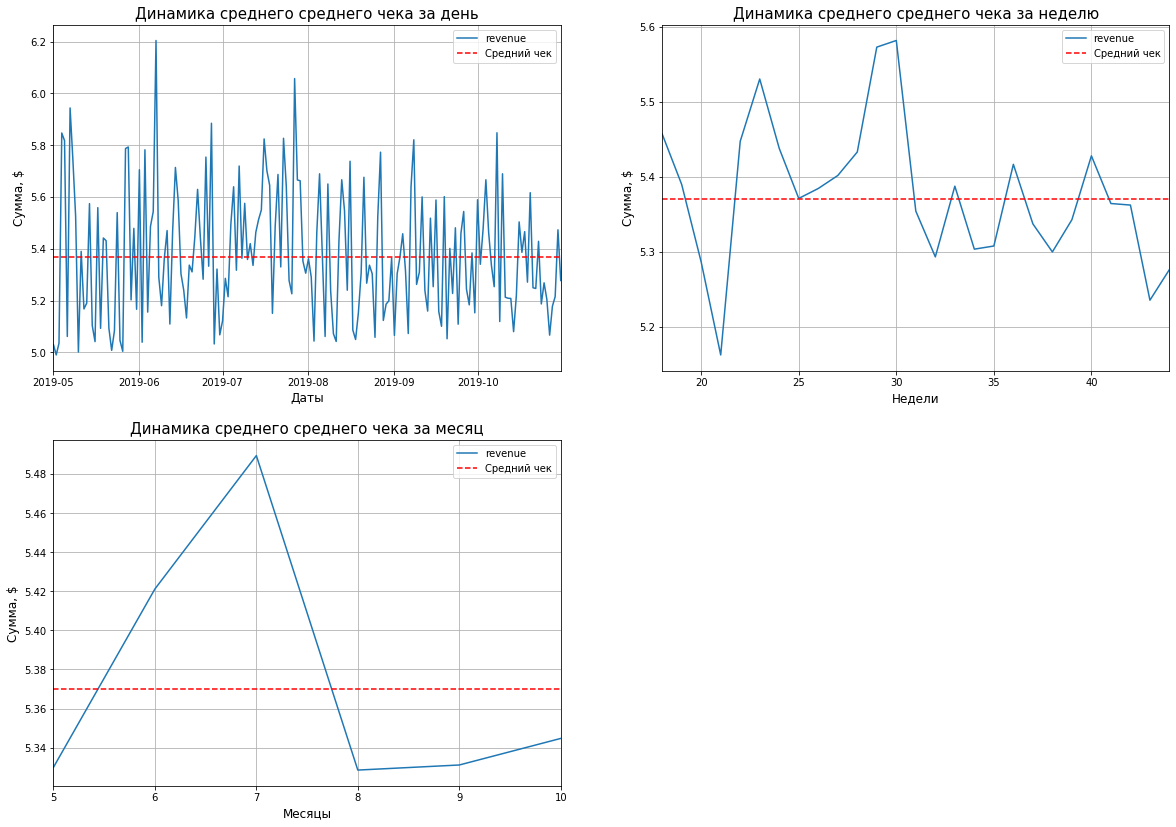

In [33]:
# график динамики среднего среднего чека 
list_of_data_revenue = [avg_revenue_day, avg_revenue_week, avg_revenue_month]

plt.figure(figsize=(20, 14))
i=1
j=0
for key in dict_of_columns_lables_date:
    list_of_data_revenue[j].plot(grid=True, ax=plt.subplot(2, 2, i))
    plt.axhline(y=5.37, color='red', linestyle='--', label='Средний чек')
    plt.legend()
    plt.title('Динамика среднего среднего чека за {}'.format(list_of_lables_date[j]), fontsize=15)
    plt.xlabel('{}'.format(dict_of_columns_lables_date[key]), fontsize=12) 
    plt.ylabel('Сумма, $', fontsize=12)
    i += 1
    j += 1   

Ежедневно средний чек варьируется от 5 до 6,2 долларов. При рассмотрении недельной динамики, мы видим резкие колебания в период с 18 по 31 неделю, далее колебания находились в пределах 0,10 - 0,20$. Месячная динамика показывает резкий рост среднего чека в мае - июне с 5,33 до 5,47 долларов и затем такое же стремительное падение в июле. После чего в августе - октябре наблюдается незначительный рост суммы среднего чека. 

### Маркетинг

- Сколько денег потратили? Всего / на каждый источник / по времени

Посчитаем общую сумму расходов на маркетинг. Выясните, как траты распределены по источникам и визуализируйте изменения метрик во времени.

In [34]:
print('Общая сумма расходов на маркетинг: {}$'.format(costs['costs'].sum().round(1)))

Общая сумма расходов на маркетинг: 105497.3$


Text(0, 0.5, 'Рекламный источник')

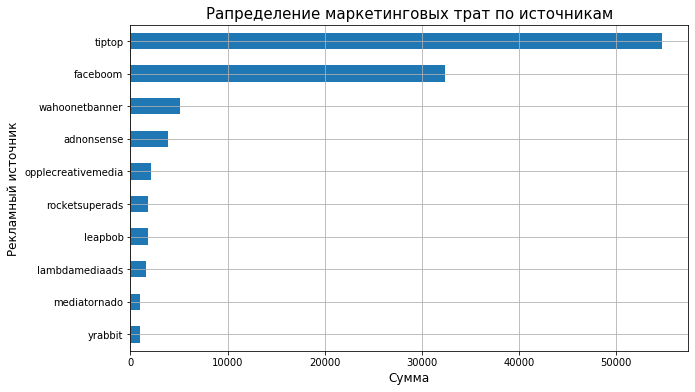

In [35]:
# рапределение трат по источникам
costs.groupby('channel')['costs'].sum().sort_values().plot(kind='barh', grid=True, figsize=(10,6))
plt.title('Рапределение маркетинговых трат по источникам', fontsize=15)
plt.xlabel('Сумма', fontsize=12) 
plt.ylabel('Рекламный источник', fontsize=12)

In [36]:
# рапределение трат по источникам
costs.groupby('channel')['costs'].sum().sort_values(ascending=False)

channel
tiptop                54751.30
faceboom              32445.60
wahoonetbanner         5151.00
adnonsense             3911.25
opplecreativemedia     2151.25
rocketsuperads         1833.00
leapbob                1797.60
lambdamediaads         1557.60
mediatornado            954.48
yrabbit                 944.22
Name: costs, dtype: float64

Маркетинговые траты сильно отличаются на разные источники. **Резко выделяются 2 источника - это tiptop и faceboom c общими рекламными тратами в 54 и 32 тыс. долларов соответственно.** На остальные источники привлечения клиентов было потрачено от 5 тыс. до 900 долларов.

In [37]:
# выделяем номер месяца из даты маркетинговых трат
costs['dt_month'] = pd.to_datetime(costs['dt']).dt.month

Text(0, 0.5, 'Сумма, $')

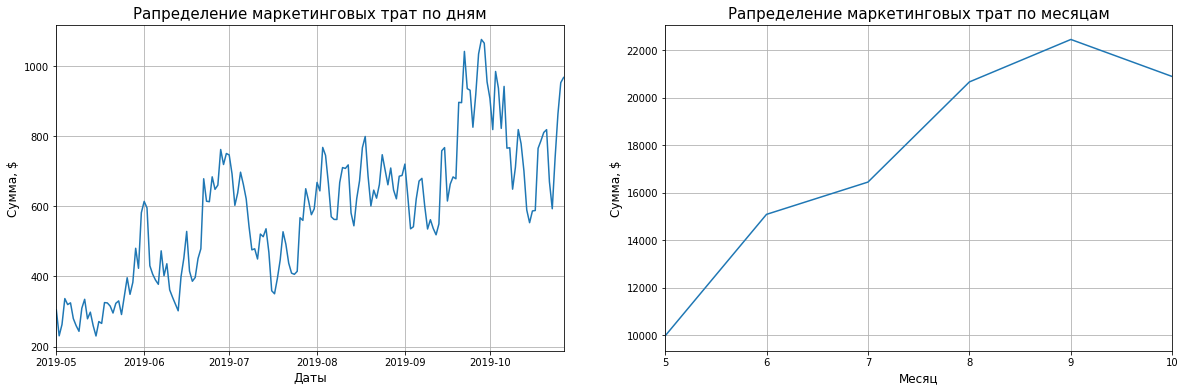

In [38]:
plt.figure(figsize=(20, 6))

# динамика маркетинговых трат по дням
ax=plt.subplot(1, 2, 1)
costs.groupby('dt')['costs'].sum().plot(grid=True)
plt.title('Рапределение маркетинговых трат по дням', fontsize=15)
plt.xlabel('Даты', fontsize=12) 
plt.ylabel('Сумма, $', fontsize=12)

# динамика маркетинговых трат по месяцам
ax=plt.subplot(1, 2, 2)
costs.groupby('dt_month')['costs'].sum().plot(grid=True)
plt.title('Рапределение маркетинговых трат по месяцам', fontsize=15)
plt.xlabel('Месяц', fontsize=12) 
plt.ylabel('Сумма, $', fontsize=12)

**В целом маркетинговые траты растут.** В мае ежедневные маркетинговые траты составляли около 300 - 400 долларов, а в сентябре - октябре уже 600 - 1000 долларов. Мы можем наблюдать интересную особенность - ежедневные маркетинговые траты имеют такое же колебание, как и динамика ежедневного количества пользователей в приложении, то есть снижение к середине месяца и увеличение к концу месяца. Пик ежедневных маркетинговых трат пришелся на вторую половину сентября.  
**Ежемесячные маркетинговые траты также выросли** с 10 - 15 тыс. долларов в мае до 22 тыс. к сентябрю. Однако к октябрю они сокращаю на 1 тыс. Опять же данная картина полностью повторяет динамику ежемесячного количества пользователей в приложении.

Text(0, 0.5, 'Cумма, $')

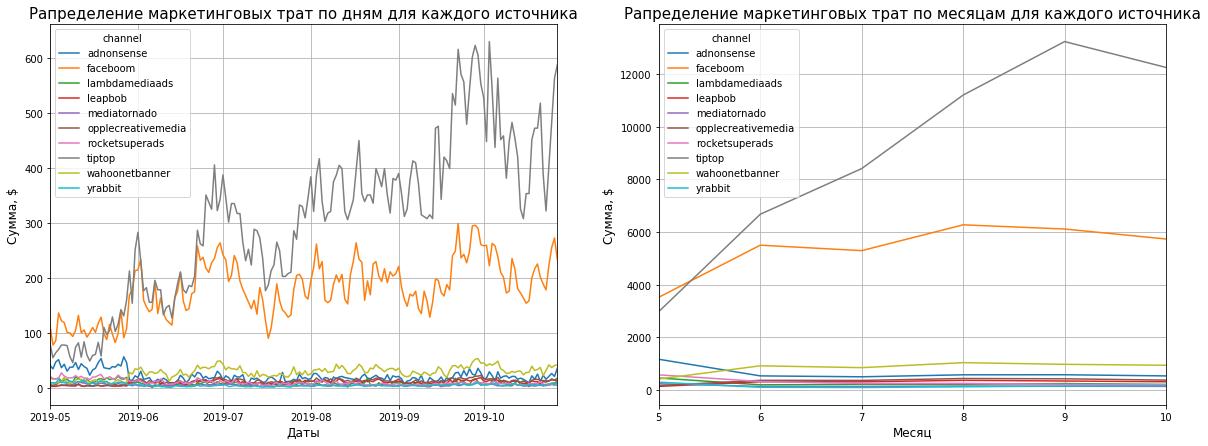

In [39]:
plt.figure(figsize=(20, 7))

# динамика маркетинговых трат по дням и источникам
costs.pivot_table(index='dt', values='costs', columns=['channel'], aggfunc='sum').plot(grid=True, ax=plt.subplot(1, 2, 1))
plt.title('Рапределение маркетинговых трат по дням для каждого источника', fontsize=15)
plt.xlabel('Даты', fontsize=12) 
plt.ylabel('Cумма, $', fontsize=12)

# динамика маркетинговых трат по месяцам и источникам
costs.pivot_table(index='dt_month', values='costs', columns=['channel'], aggfunc='sum').plot(grid=True, ax=plt.subplot(1, 2, 2))
plt.title('Рапределение маркетинговых трат по месяцам для каждого источника', fontsize=15)
plt.xlabel('Месяц', fontsize=12) 
plt.ylabel('Cумма, $', fontsize=12)

Динамика маркетинговых трат показывает, что на источники tiptop и faceboom ежедневные затраты выросли с 100 долларов до 300 - 600 и 200 - 300 долларов соответственно, в то время как на остальные источники ежедневные маркетинговые траты составляют 50 долларов и менее.   
Ежемесячные траты на faceboom составляли от 4 до 6 тыс. долларов и  можно заметить, что они практически не меняются с июня, а вот траты на tiptop в два раза выросли к сентябрю с 7 до 13 тысяч долларов, затем начали немного снижаться. Ежемесячные маркетинговые траты на другие источники не превышают 1 тыс. долларов.

- Сколько в среднем стоило привлечение одного пользователя из каждого источника?

Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника. Рассчитаем средний CAC на одного пользователя (стоимость привлечения одного клиента) для всего проекта и для каждого источника трафика. 

In [40]:
print('Средняя стоимость привлечения одного пользователя: {}$'.format(profiles['acquisition_cost'].mean().round(2)))

Средняя стоимость привлечения одного пользователя: 0.7$


In [41]:
cac_by_channel = (profiles.groupby('channel')['acquisition_cost'].mean()).round(2).sort_values(ascending=False)
cac_by_channel.to_frame(name='cac_by_channel')

,cac_by_channel
channel,
tiptop,2.80
faceboom,1.11
adnonsense,1.01
lambdamediaads,0.72
wahoonetbanner,0.60
rocketsuperads,0.41
opplecreativemedia,0.25
yrabbit,0.22
mediatornado,0.22


**Наиболее дорого обходятся клиенты, приходящие из канала tiptop - в 2,8 доллара в среднем**, стоимость привлечения таких клиентов превышает среднюю стоимость привлечения клиентов в 4 раза. На втором месте клиенты faceboom и adnonsense, их стоимость привлечения составляет около 1 доллара. Остальные клиенты обходятся компании в 70 центов и ниже.  

### Вывод

1. Мы выяснили, что ежедневное и ежемесячное количество пользователей приложения напрямую зависит от маркетинговых трат.
2. Вероятно рекламная кампания в июле была самой удачной, так как произошел резкий рост количества пользователей, однако после сентября это количество начало немного снижаться.
3. В основном совершается от 1250 до 2250 пользовательских сессий в день, в среднем 1684. При этом половина сессий длятся 21 минуту и более, и лишь 25% сессий составляют не более 9 минут, что в целом хороший показатель.
4. Мы узнали, что среднее время от первого посещения до покупки: 45 часов. Можно сделать вывод, что в среднем пользователи оценивают приложение около 2 дней, после чего совершают покупки. При этом пользователи делают в среднем чуть менее 2,5 покупок в месяц. Резкое снижение наблюдалось в июле и августе - до 2 покупок в месяц. 
5. Средний чек составляет 5.37 долларов. Ежедневный средний чек варьируется от 5 до 6,2 долларов. Хотя при отслеживании еженедельной и ежемесячной динамики наблюдалась резкие скачки в сумме среднего чека, однако в целом они составляли не боле 40 центов в неделю и не более 12 центов в месяц.
6. Мы выяснили, что общая сумма расходов на маркетинг составила 105497.3 долларов. Большую часть заняли расходы на привлечение пользователей из каналов tiptop и faceboom - 54 и 32 тыс. долларов соответственно. На остальные же источники привлечения клиентов было потрачено от 5 тыс. до 900 долларов.
7. В целом маркетинговые траты постоянно растут, однако это опять же обусловлено ростом расходов на привлечение пользователей каналов tiptop и faceboom. При этом ежемесячные траты на faceboom за весь период выросли всего на 2 тыс. долларов, а вот на tiptop примерно на 9 тыс. долларов. 
8. Средняя стоимость привлечения одного пользователя составляет 0.7 долларов, а самые дорогие клиенты, приходящие из канала tiptop, стоимость их привлечения в 4 раза выше средней стоимости привлечения клиентов. На втором месте клиенты faceboom и adnonsense.

## Функции для расчета и анализа LTV, ROI, удержания и конверсии


Зададим функции для расчёта и визуализации LTV, ROI, удержания и конверсии. 

In [42]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [43]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [44]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [45]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [46]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [47]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [48]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Окупаемость рекламы для привлечения пользователей

Опишите проблемы, которые вы обнаружили. Ответьте на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучите конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

Опишите возможные причины обнаруженных проблем и сформируйте рекомендации для рекламного отдела. 

Установим момент и горизонт анализа данных. На календаре 1 ноября 2019 года. Зададим двухнедельный горизонт анализа и исключим пользователей, которые пришли из канала organic, так как мы не платим за привлечение этих пользователей.

In [49]:
# момент анализа
observation_date = datetime(2019, 11, 1).date()  

# горизонт анализа
horizon_days = 14   

# исключение пользователей organic
profiles_filtered = profiles.query('channel not in ("organic")')

### Анализ общей окупаемости рекламы

Проанализируем общую окупаемость рекламы и построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

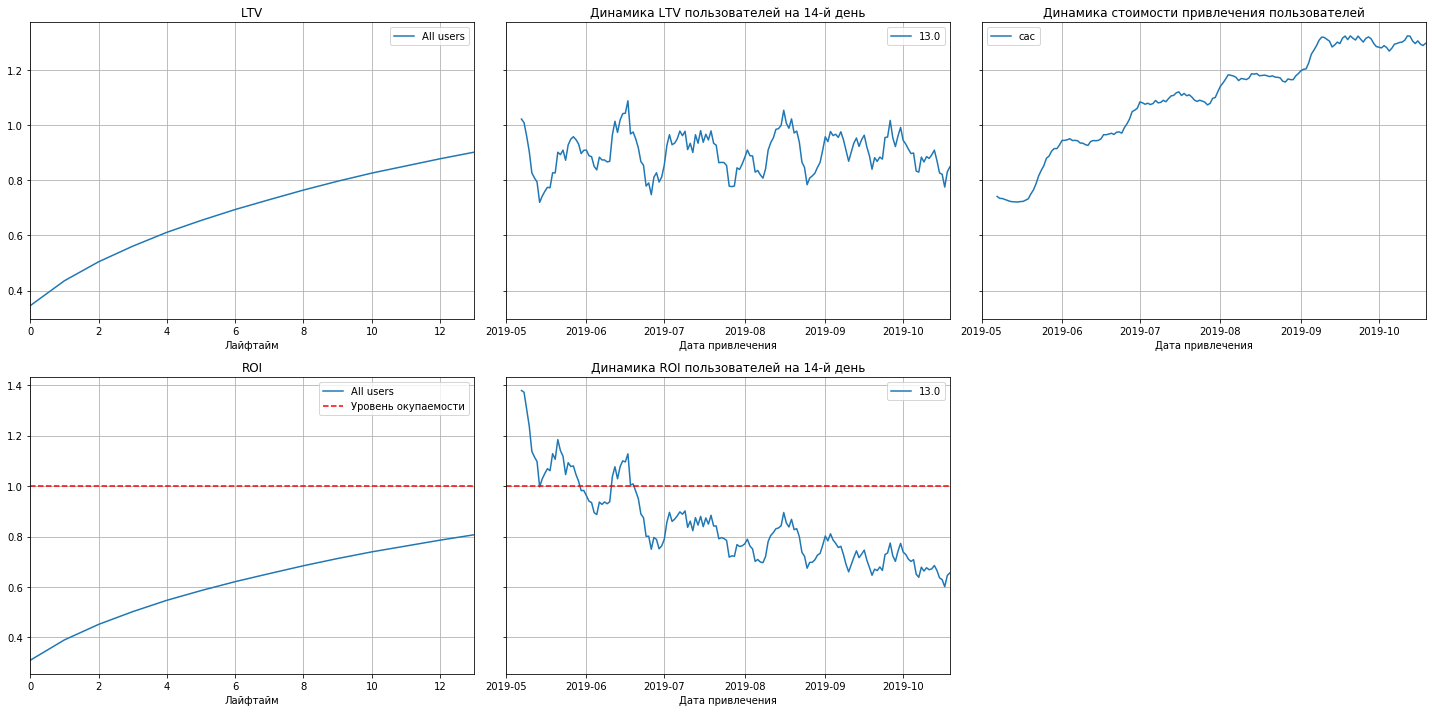

In [50]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_filtered, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

1. На LTV влияет сезонный фактор, но и этот показатель достаточно стабилен. Качество пользователей не ухудшилось.
2. САС постоянно увеличивается, при этом реклама не окупается и даже к концу второй недели RIO на уровне 80%.
3. Пользователи, привлеченные до июня, а также в середине июня, окупали затраты на рекламу на конец второй недели. 

Чтобы разобраться в причинах, сделаем анализ по всем доступным характеристикам пользователей — стране, источнику и устройству первого посещения.

### Анализ окупаемости рекламы с разбивкой по устройствам

Проанализируем окупаемость рекламы с разбивкой по устройствам, построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

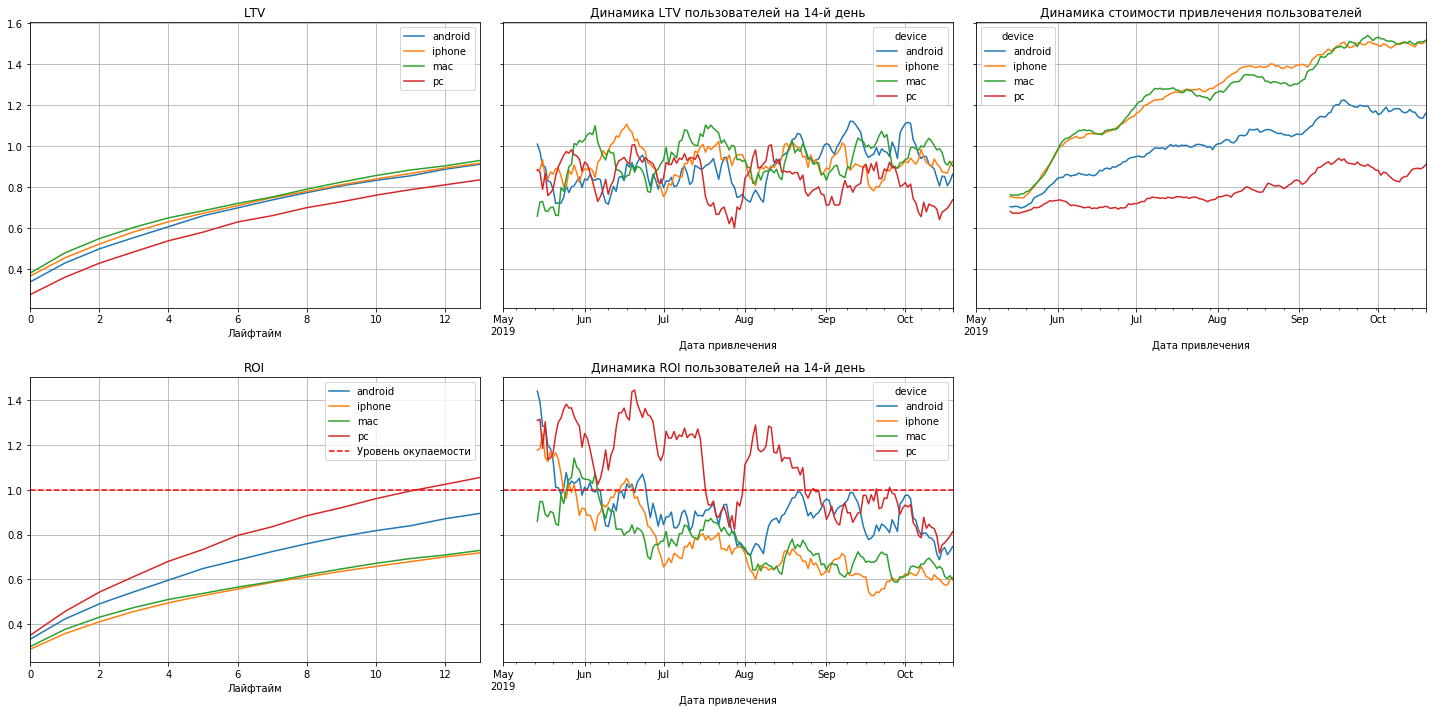

In [51]:
# окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_filtered, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

1. LTV достаточно стабилен, однако пользователи PC приносят меньше денег компании.
2. Стоимость привлечения пользователей mac и iphone гораздо выше стоимости привлечения пользователей andriod, а привлечение пользователей pc обходится дешевле всех. При этом окупаемость затрат на рекламу абсолютно противоположна: пользователи рс окупаются на 12 день, а пользователи mac, iphone и andriod не окупаются вообще. Их ROI к концу второй недели около от 70 до 90%.
3. Пользователи рс, привлеченные в сентябре октябре также перестали окупаться, RIO  на 14 день не доходит до 100%.

### Анализ окупаемости рекламы с разбивкой по странам

Проанализируем окупаемость рекламы с разбивкой по странам и построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

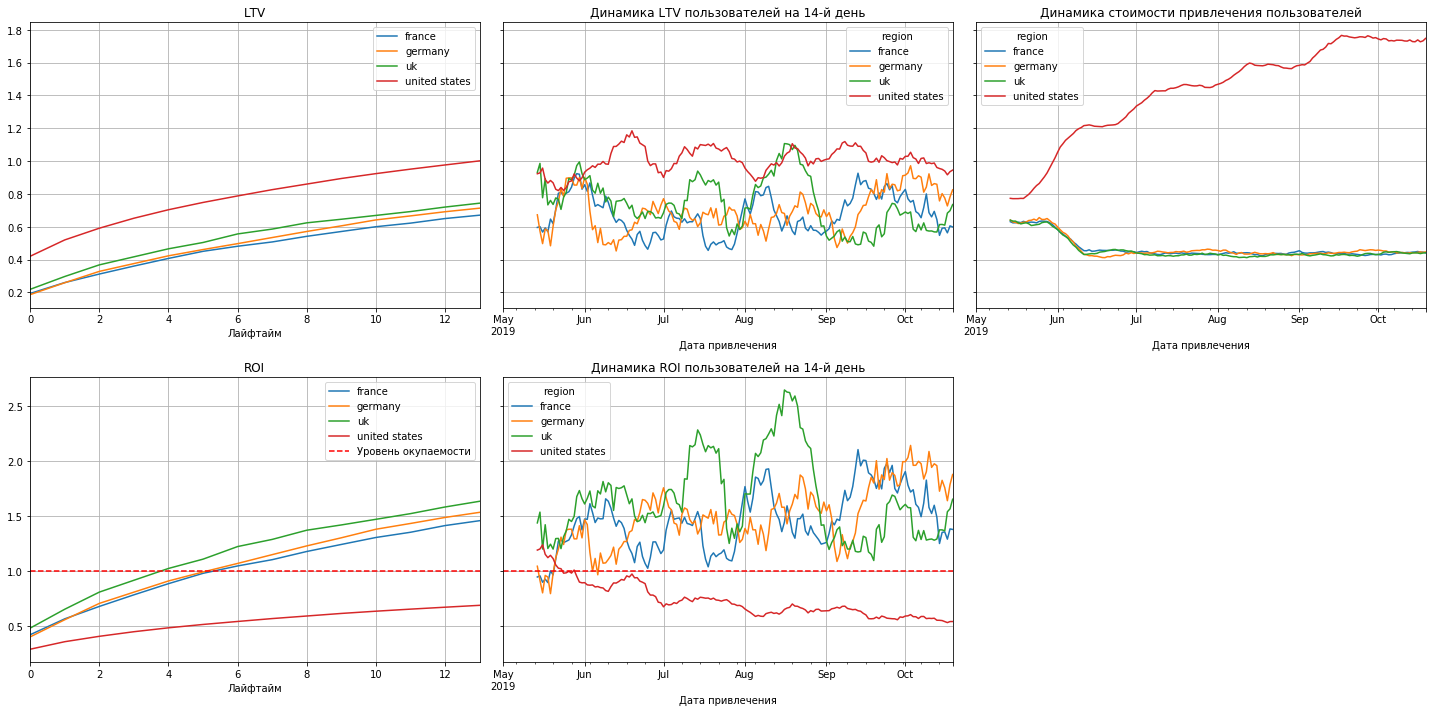

In [52]:
# окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_filtered, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

1. Пользователи из США приносят значительно больше денежных средств компании, чем пользователи из других стран. Однако стоимость привлечения этих пользователей сильно превышает прибыль от них и как следствие мы можем наблюдать, что затраты на привлечение этих пользователей совершенно не окупаются. ROI к концу второй недели около 70%.
2. Затраты на привлечение пользователей из Великобритании окупаются на 5 день, а из Франции и Германии на 6 день. К концу второй недели ROI составляет 150 - 160%. Пользователи из Великобритании, привлеченные в середине июля и в середине августа показывали самый высокий ROI на 14 день.
3. Затраты на привлечение пользователей из США резко выросли в июне и в это же время перестало окупаться привлечение новых пользователей.

### Анализ окупаемости рекламы с разбивкой по рекламным каналам

Проанализируем окупаемость рекламы с разбивкой по рекламным каналам и построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

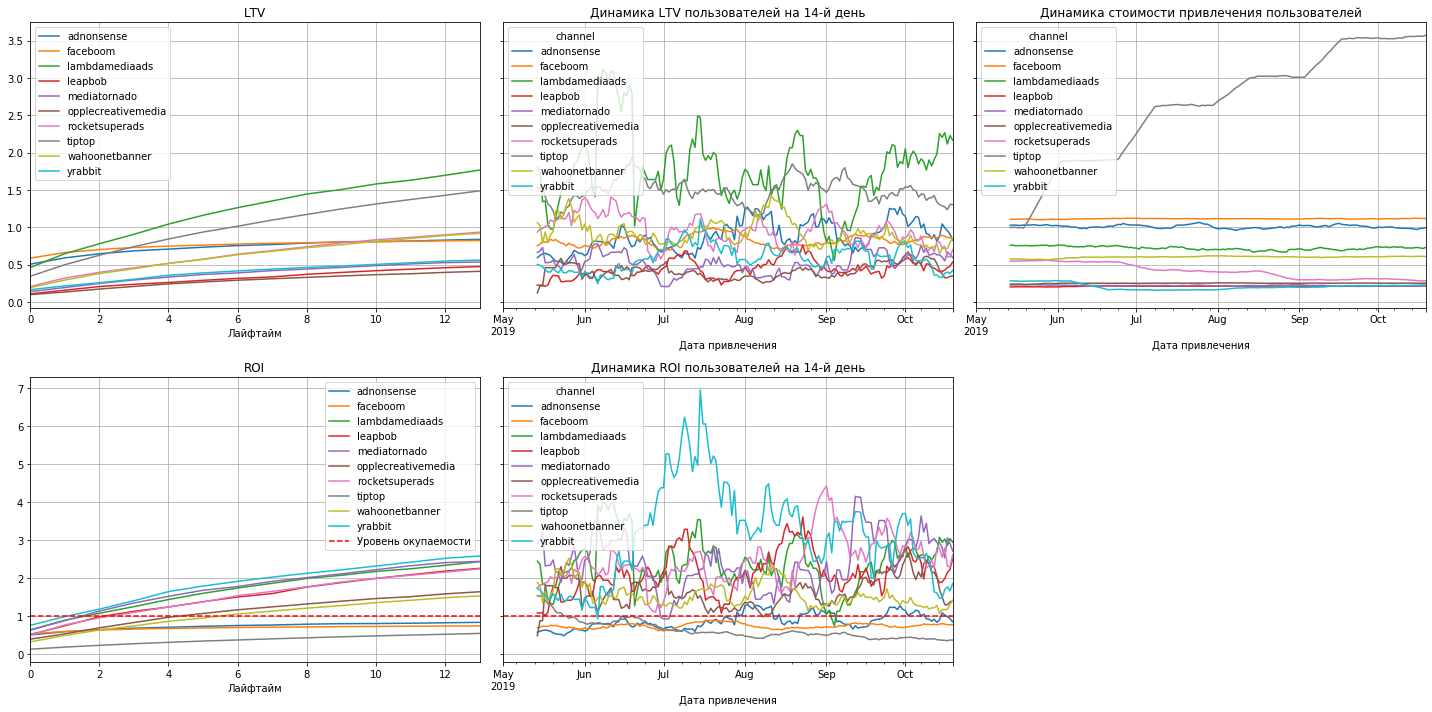

In [53]:
# окупаемость с разбивкой по каналам привлечения
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_filtered, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

1. Клиенты, привлеченные из lambdamediaads и tiptop больше всего приносят денег компании. 
2. Стоимость привлечения клиентов tiptop резко выделяется, она растет ежемесячно и и концу октября превышает стоимость привлечения других клиентов во много раз. Стоимость привлечения клиентов из других источников остается стабильной, а из rocketsuperads даже снижается.
3. Затраты на привлечение клиентов из tiptop, faceboom и adnonsense не окупаются.
4. Затраты на привлечение клиентов из остальных источников окупаются на 4 - 6 день. Клиенты из канала yrabbit, привлеченные в июле, показывают лучшую динамику RIO на 14 день.

### Анализ конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам

Построим и изучим графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.  

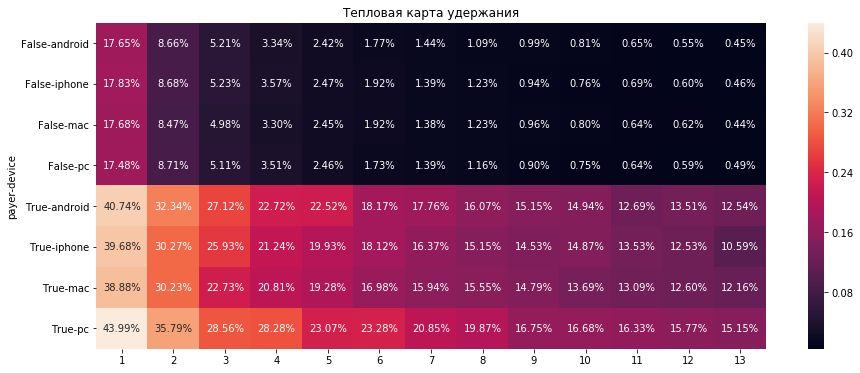

In [54]:
# тепловая карта с разбивкой по устройствам
retention_raw, retention_grouped, retention_in_time = get_retention (
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plt.figure(figsize=(15, 6))
sns.heatmap(retention_grouped.drop(columns=['cohort_size', 0]), annot=True, fmt='.2%')
plt.title('Тепловая карта удержания')
plt.show()

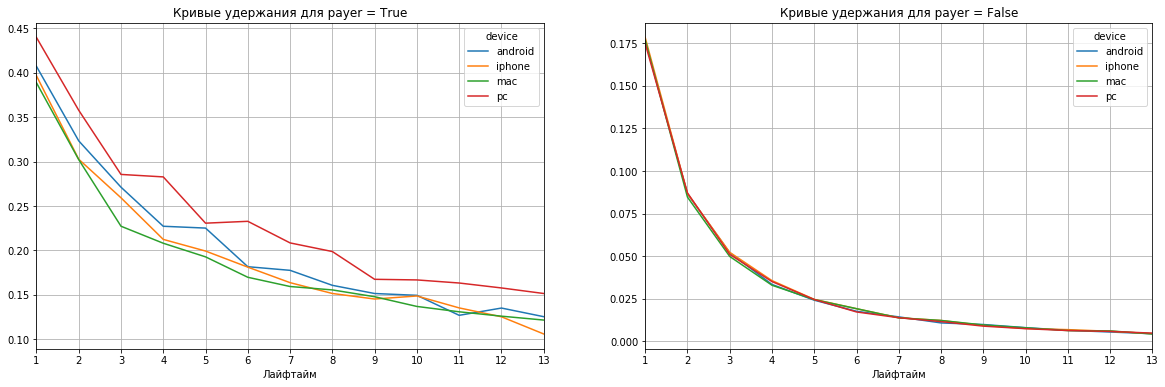

In [55]:
# кривые удержания 

plt.figure(figsize=(20, 6))

# исключаем размеры когорт и удержание первого дня
report = retention_grouped.drop(columns=['cohort_size', 0])

for i, payer in enumerate(profiles['payer'].unique()):
    report.query('payer == @payer').droplevel('payer').T.plot(
        grid=True,
        xticks=list(report.columns.values),
        ax=plt.subplot(1, 2, i + 1),
    )
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания для payer = {}'.format(payer))

plt.show()

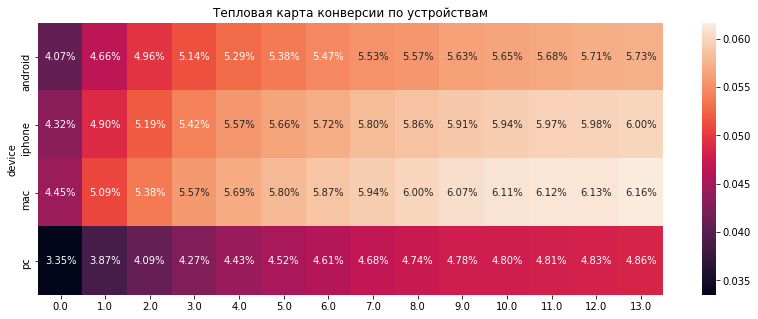

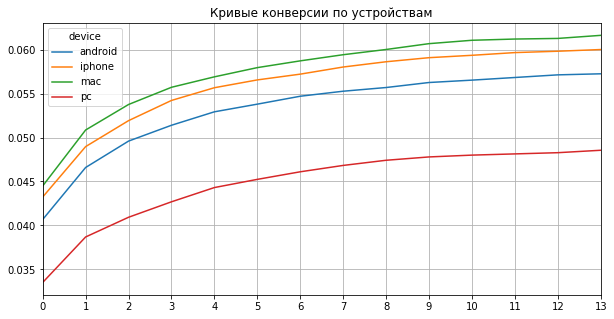

In [56]:
# получаем сырые данные, таблицу конверсии и таблицу динамики конверсии
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

# исключаем размеры когорт
report = conversion.drop(columns = ['cohort_size'])

# строим тепловую карту
plt.figure(figsize=(14, 5))
sns.heatmap(report, annot=True, fmt='.2%')  
plt.title('Тепловая карта конверсии по устройствам')
plt.show() 

# кривые конверсии
report.T.plot(grid=True, xticks=list(report.columns.values), figsize = (10, 5))  
plt.title('Кривые конверсии по устройствам')
plt.show() 

1. Лучше всего удерживаются платящие пользователи pc и andriod, как на второй день - 40-43%, так и в конце второй недели 15-12%. 
2. Неплатящие пользователи разных устройств удерживаются одинаково - чуть менее 0,5% к концу второй недели.   
3. Лучше всего конвертируются пользователи mac и iphone, а вот пользователи pc не охотно становятся покупателями.

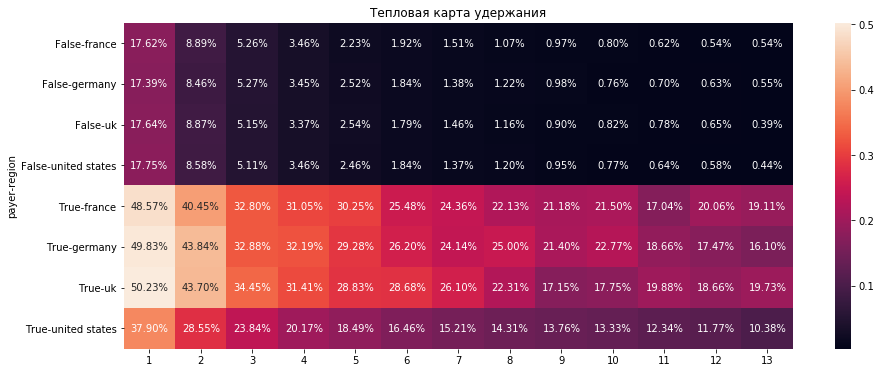

In [57]:
# тепловая карта с разбивкой по странам
retention_raw, retention_grouped, retention_in_time = get_retention (
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plt.figure(figsize=(15, 6))
sns.heatmap(retention_grouped.drop(columns=['cohort_size', 0]), annot=True, fmt='.2%')
plt.title('Тепловая карта удержания')
plt.show()

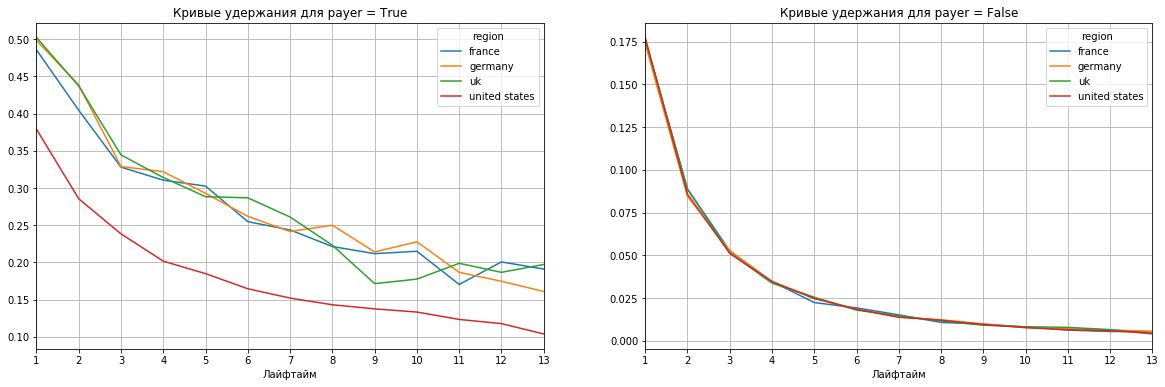

In [58]:
# кривые удержания 

plt.figure(figsize=(20, 6))

# исключаем размеры когорт и удержание первого дня
report = retention_grouped.drop(columns=['cohort_size', 0])

for i, payer in enumerate(profiles['payer'].unique()):
    report.query('payer == @payer').droplevel('payer').T.plot(
        grid=True,
        xticks=list(report.columns.values),
        ax=plt.subplot(1, 2, i + 1),
    )
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания для payer = {}'.format(payer))

plt.show()

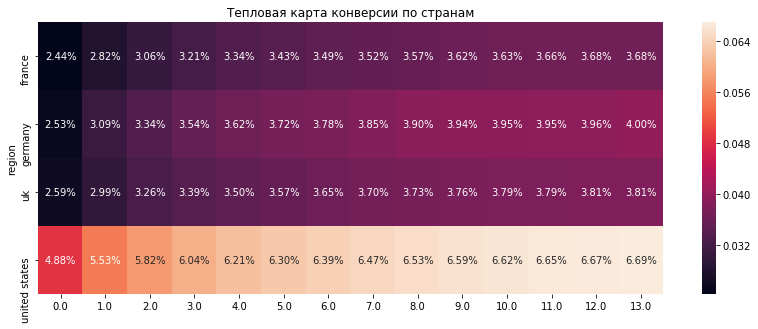

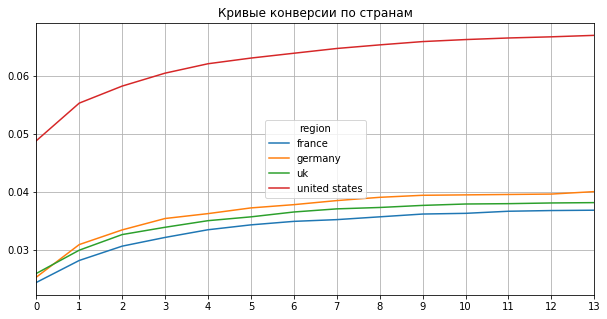

In [59]:
# получаем сырые данные, таблицу конверсии и таблицу динамики конверсии
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

# исключаем размеры когорт
report = conversion.drop(columns = ['cohort_size'])

# в строим тепловую карту
plt.figure(figsize=(14, 5))
sns.heatmap(report, annot=True, fmt='.2%')  
plt.title('Тепловая карта конверсии по странам')
plt.show() 

 # кривые конверсии
report.T.plot(grid=True, xticks=list(report.columns.values), figsize=(10, 5)) 
plt.title('Кривые конверсии по странам')
plt.show() 

1. Платящие пользователи Франции, Германии и Великобритании удерживаются одинаково от 50% на второй день до чуть менее 20% к концу второй недели. А вот платящие пользователи США удерживаются значительно хуже, удержание в второй день 37% и снижается до 10% к концу второй недели.
2. Неплатящие пользователи всех стран удерживаются одинаково хуже платящих.
3. Пользователи из США гораздо чаще становятся покупателями, чем пользователи из других стран.

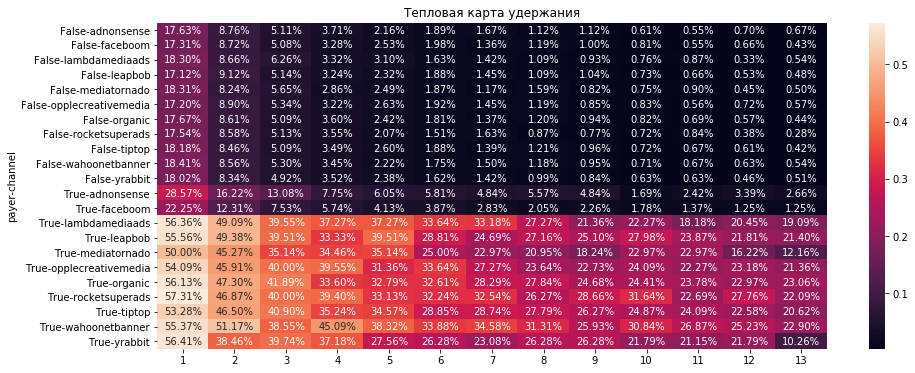

In [60]:
# тепловая карта с разбивкой по каналам привлечения
retention_raw, retention_grouped, retention_in_time = get_retention (
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plt.figure(figsize=(15, 6))
sns.heatmap(retention_grouped.drop(columns=['cohort_size', 0]), annot=True, fmt='.2%')
plt.title('Тепловая карта удержания')
plt.show()

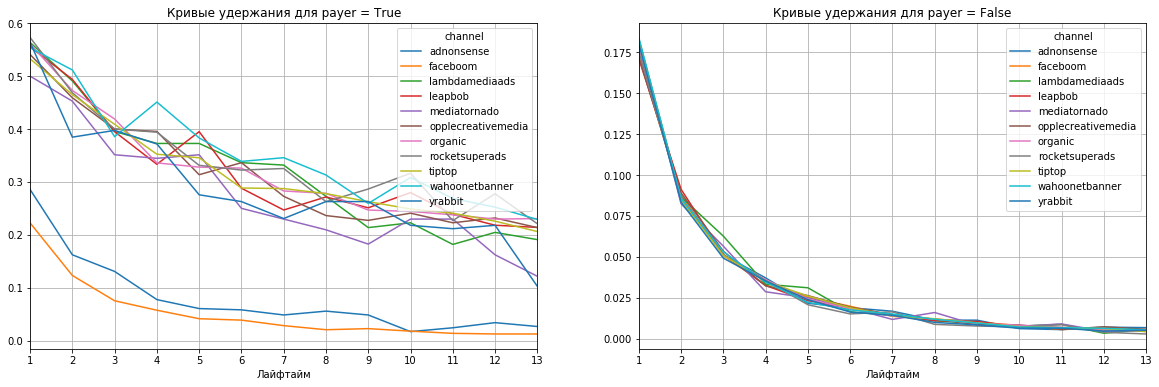

In [61]:
# кривые удержания 

plt.figure(figsize=(20, 6))

# исключаем размеры когорт и удержание первого дня
report = retention_grouped.drop(columns=['cohort_size', 0])

for i, payer in enumerate(profiles['payer'].unique()):
    report.query('payer == @payer').droplevel('payer').T.plot(
        grid=True,
        xticks=list(report.columns.values),
        ax=plt.subplot(1, 2, i + 1),
    )
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания для payer = {}'.format(payer))

plt.show()

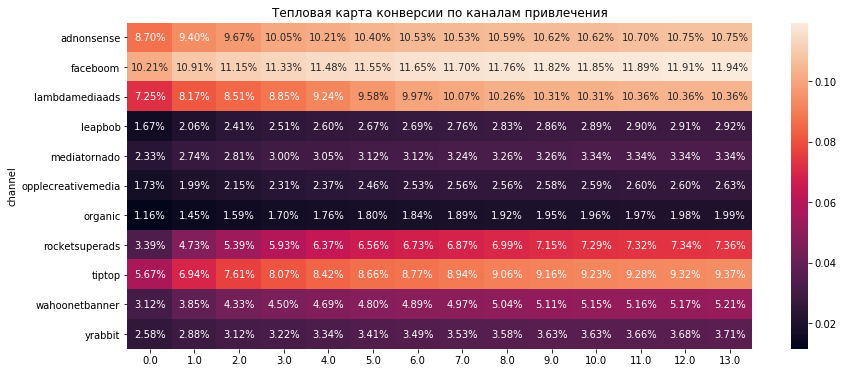

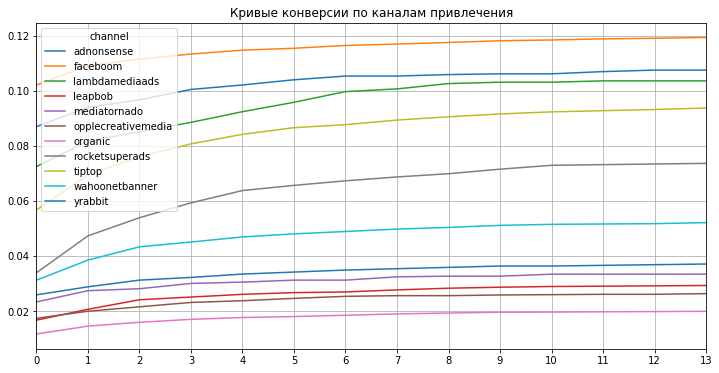

In [62]:
# получаем сырые данные, таблицу конверсии и таблицу динамики конверсии
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

# исключаем размеры когорт
report = conversion.drop(columns = ['cohort_size'])

# строим тепловую карту
plt.figure(figsize = (14, 6)) 
sns.heatmap(report, annot=True, fmt='.2%')  
plt.title('Тепловая карта конверсии по каналам привлечения')
plt.show() 

# кривые конверсии
report.T.plot(grid=True, xticks=list(report.columns.values), figsize = (12, 6))  
plt.title('Кривые конверсии по каналам привлечения')
plt.show() 

1. Явные аутсайдеры здесь - это платящие пользователи из каналов faceboom и adnonsense. На второй день они удерживаютя в 2 раза хуже платящих пользователей из других каналов, на 14 день в 10 - 20 раз хуже.
2. Неплатящие пользователи удерживаются одинаково плохо.
3. Пользователи каналов faceboom лучше всех конвертируются, а хуже всего органические пользователи. 

### Вывод

1. В целом реклама не окупается даже к концу второй недели. Однако пользователи, привлеченные до июня и в середине июля, окупали затраты на рекламу.  
2. Пользователи, которые снижают окупаемость рекламы:
- пользователи mac, iphone и android;
- пользователи из США;
- пользователи, привлеченные из каналов tiptop, faceboom и adnonsense.  
Такие пользователи не окупаются даже на 14 день.
3. Вероятные причины низкой окупаемости рекламы:
- высокая стоимость привлечения пользователей mac и iphone, при этом низкое их удержание;
- пользователи рс, привлеченные в сентябре октябре также перестали окупаться;
- пользователи из США удерживаются хуже пользователей из других стран начиная сразу со второго дня. Затраты на привлечение резко выросли в июне и с этого же периода перестали окупаться;
- затраты на привлечение пользователей из канала tiptop во много раз выше затрат на привлечение пользователей из других каналов и ежемесячно продолжают расти. Удержание клиентов из каналов faceboom и adnonsense очень низкое, в то время как затраты на их привлечение выше других затрат. 
4. Возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела:
- пользователи mac и iphone плохо удерживаются и так как они являются пользователями устройств Apple, то можно предположить, что здесь присутствуют технические пролемы, такие как: приложение плохо, либо неудобно адаптировано под устройства Apple, проблемы с обновлениями на устройствах Apple или ошибки, возникающие при работе на данных устройствах. Так как конверсия  пользователей mac и iphone очень высокая, то необходимо повысить их удержание. Изучить отзывы пользователей устройств Apple, либо провести опрос оценки качества использования приложения, а также дополнительно протестировать работу приложения на данных устройствах.
- стоимость привлечения пользователей mac и iphone очень высокая, а вот стоимость привлечения пользователей pc наоборот низкая, хотя платящие пользователи pc отлично удерживаются. Необходимо привлекать больше новых пользователей рс и повысить их конвертацию.
- пользователей из США большое количество и они отлично конвертируются, однако плохо удерживаются. Их привлекает реклама, они совершают покупки, но быстро теряют интерес к приложению. Возможно контент не актуален для данной группы пользователей, либо есть местный популярный конкурент.  
- стоимость привлечения пользователей из канала tiptop неоправданно высокая. Компания тратит больше всего денег на привлечение этих пользователей, однако их удержание и конверсия имеют средние значения, а по количеству пользователей канал занимает третье место. Возможно пользователи этого канала не самая подходящая целевая аудитория (например: дети или подростки, которые не заинтересованы в продукте компании).
- пользователи из каналов faceboom и adnonsense отлично конвертируются, но плохо удерживаются. При этом из канала adnonsense приходит мало пользователей. Стоит повысить удержание этих пользователей и привлечь больше пользователей из канала adnonsense.
- в июле прошла удачная рекламная компания для пользователей из канала yrabbit, что показывает динамика ROI на 14 день. Окупаемость рекламы для этих пользователей высокая и удержание на среднем уровне, возможно стоит привлечь большее количество клиентов и повысить конверсию.
- пользователи lambdamediaads приносят компании больше всего денег, они стабильно удерживаются и конвертируются, а стоимость их привлечения средняя. Стоит сделать упор также на привлечение дополнительных пользователей и этого канала.

## Общие выводы

- Причины неэффективности привлечения пользователей:
1. Начиная с июня компания производит слишком высокие траты на привлечение пользователей mac и iphone, у которых остается низкое удержание. 
2. У пользователей pc отмечается хорошее удержание, но низкая конвертация.
3. Также с июня заметно выросли маркетинговые траты на привлечение пользователей в США, однако эти пользователи хуже всех удерживаются.
4. С июня заметно выросли маркетинговые траты на привлечение пользователей tiptop. Однако они не оправдывают себя, так как было привлечено не самое большое количество пользователей, а показатели конверсии и удержания остались на среднем уровне. Возможно пользователи канала не подходящая целевая аудитория.
5. Привлечение пользователей каналов faceboom и adnonsense обходится дорого, но эти пользователи хуже всех удерживаются. 

- Рекомендации для отдела маркетинга для повышения эффективности:
1. Повысить удержание пользователей mac и iphone. Выявить причины плохого удержания пользователей устройств Apple, проверить связано ли это с техническими проблемами приложения.   
2. Повысить конвертацию пользователей pc.
3. Повысить удержание пользователей из США, так как они охотно конвертируются, их LTV самый высокий.
4. Придериваться июльской стратегии привлечения пользователей в Великобритании, так как эти пользователи показали самый высокий ROI на 14 день.
5. Снизить расходы на привлечение пользователей из канала tiptop.
6. Пользователи каналов  faceboom и adnonsense отлично конвертируются, стоит повысит их удержание.
7. Сделать также упор на привлечение дополнительных пользователей из канала lambdamediaads. Их LTV самый высокий, они стабильно удерживаются и конвертируются, а стоимость их привлечения средняя. 
8. Повторить июльскую рекламную компанию для пользователей канала yrabbit, так как пользователи, привлеченные в июле имеют самую высокую динамика ROI на 14 день. Окупаемость рекламы для этих пользователей высокая, возможно стоит привлечь большее количество клиентов и повысить конверсию.